<a href="https://colab.research.google.com/github/ikyro/mnist/blob/main/mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download `training data` and `test data`

In [1]:
from torchvision import datasets
from torchvision.transforms import ToTensor

training_data = datasets.MNIST(
  root='data',
  train=True,
  download=True,
  transform=ToTensor()
)

test_data = datasets.MNIST(
  root='data',
  train=False,
  download=True,
  transform=ToTensor()
)

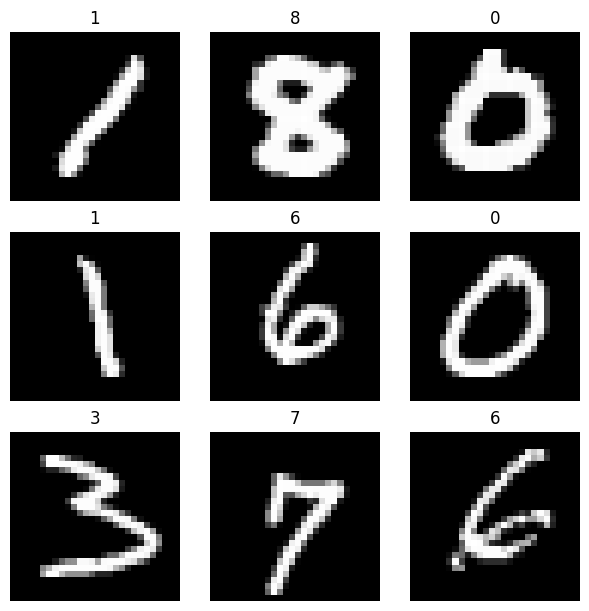

In [2]:
import matplotlib.pyplot as plt
import torch

figure = plt.figure(figsize=(6, 6), layout='constrained')
cols = 3
rows = 3

for i in range(cols * rows):
  rand_index = torch.randint(len(training_data), size=(1,)).item()
  img, label = training_data[rand_index] # type: ignore
  figure.add_subplot(rows, cols, i + 1)
  plt.title(label)
  plt.axis('off')
  plt.imshow(img.squeeze(), cmap='gray')

plt.show()

In [3]:
print(
  f'training data size: {training_data.data.size()}',
  f'test data size: {test_data.data.size()}',
  sep='\n'
)

#print(training_data.data.size()[1:])

training data size: torch.Size([60000, 28, 28])
test data size: torch.Size([10000, 28, 28])


In [4]:
from torch import cuda

device = 'cuda' if cuda.is_available() else 'cpu'

print(f'using: {device}')

using: cpu


In [5]:
from torch import nn

class NeuralNetwork(nn.Module):
  def __init__(self):
    super().__init__()

    self.flatten = nn.Flatten()
    self.linear_relu_stack = nn.Sequential(
      nn.Linear(in_features=28*28, out_features=512),
      nn.ReLU(),
      nn.Linear(in_features=512, out_features=512),
      nn.ReLU(),
      nn.Linear(in_features=512, out_features=10),
      nn.Softmax()
    )

  def forward(self, x):
    x = self.flatten(x)
    logits = self.linear_relu_stack(x)

    return logits

In [6]:
from torch.utils.data import DataLoader

training_loader = DataLoader(
  training_data,
  batch_size=100,
  shuffle=True,
  num_workers=2,
  pin_memory=True,
)

test_loader = DataLoader(
  test_data,
  batch_size=100,
  shuffle=True,
  num_workers=2,
  pin_memory=True,
)

In [7]:
model = NeuralNetwork().to(device)

# Training Model

In [8]:
from torch import nn, optim
import numpy as np

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
epochs = 5

def train_model():
  for i, (inputs, labels) in enumerate(training_loader):
    inputs = inputs.to(device)
    labels = torch.tensor(labels).to(device)

    optimizer.zero_grad()
    outputs = model(inputs)
    loss = loss_fn(outputs, labels)
    
    loss.backward()
    optimizer.step()

    if i % 10 == 0:
      loss = loss.item()
      current = (i + 1) * len(inputs)

      print(f'loss: {loss:.4f} [{current:>5d}/{len(training_data):>5d}]')
  
for epoch in range(1, epochs + 1):
  print(f'training epoch: {epoch}/{epochs}')

  model.train()
  train_model()

training epoch: 1/5


C:\Users\ikyro\AppData\Local\Temp\ipykernel_5652\869947608.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)
C:\Users\ikyro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\nn\modules\container.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


loss: 2.3029 [  100/60000]
loss: 2.0916 [ 1100/60000]
loss: 1.8508 [ 2100/60000]
loss: 1.6933 [ 3100/60000]
loss: 1.7079 [ 4100/60000]
loss: 1.6338 [ 5100/60000]
loss: 1.6247 [ 6100/60000]
loss: 1.6400 [ 7100/60000]
loss: 1.6683 [ 8100/60000]
loss: 1.6561 [ 9100/60000]
loss: 1.6090 [10100/60000]
loss: 1.5935 [11100/60000]
loss: 1.5845 [12100/60000]
loss: 1.6182 [13100/60000]
loss: 1.5986 [14100/60000]
loss: 1.6722 [15100/60000]
loss: 1.6403 [16100/60000]
loss: 1.6680 [17100/60000]
loss: 1.5964 [18100/60000]
loss: 1.6223 [19100/60000]
loss: 1.6167 [20100/60000]
loss: 1.5741 [21100/60000]
loss: 1.6144 [22100/60000]
loss: 1.6092 [23100/60000]


KeyboardInterrupt: 

# Evaluation Model

In [ ]:
def eval_model():
  val_loss = []
  val_acc = []

  with torch.no_grad():
    for i, (inputs, labels) in enumerate(test_loader):
      inputs = inputs.to(device)
      labels = torch.tensor(labels).to(device)

      outputs = model(inputs)
      loss = loss_fn(outputs, labels)

      val_loss.append(loss.item())
      val_acc.append((outputs.argmax(1) == labels).float().mean().item())
      print(f"evaluation loss: {np.mean(val_loss):.4f} evaluation accuracy: {np.mean(val_acc):.4f}")

for epoch in range(1, epochs + 1):
  print(f'evaluation epoch: {epoch}/{epochs}')

  model.eval()
  eval_model()

In [ ]:
torch.save(model.state_dict(), 'model.ckpt')